# NYC High Schools: An Analysis between SAT Scores and Demographics

# Introduction

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests and whether they're unfair to certain groups. Hence, the aim of this project is to;


- Investigating the correlations between SAT scores and demographics. The study would seek to find correlation between SAT scores and factors like race, gender etc.
- Determine neighbourhoods with best high schools



The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's important to perform well.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the dataset for this project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

- The focus of this study is narrowed on high schools in New York City for the year 2011/12

New York City makes its data on high school SAT scores available online, as well as the demographics for each high school. Below are the links to all the datasets used in this project;

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City

- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City

- [Class Size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school



# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

There are two different files contained in the 'Survey' dataset. 
- survey_all.txt - Data on surveys from all schools
- survey_d75.txt - Data on surveys from New York City district 75

These two separate files will be concatenated into a single dataset 'survey'

The files are however, tab delimited and encoded with Windows-1252 encoding and this will be specified while reading the files in.

In [2]:
# Specify the encoding and delimiter - The files are tab delimited and encoded with Windows-1252 encoding
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

'Class Size' dataset does not have the 'DBN' column whiles the 'hs_directory' has the 'dbn' column which needs to be renamed to 'DBN' to be consistent with the other datasets to avoid errors when combining the datasets into a single dataframe.

However, 'Class Size' dataset has two columns; 'CSD' and 'SCHOOL CODE' which appears to be the combination used to generate the 'DBN' in the other datasets. Therefore, these two columns will be used to generate a 'DBN' column for the 'Class Size' dataset.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

The 'SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', and 'SAT Writing Avg. Score'  columns in the 'sat_results' dataset contain results for each the three sections in a SAT and are stored as a string type. These columns will be converted to numeric datatype and added together in a single 'sat_score' column in the 'sat_results' dataset. A single average SAT score will simplify the correlation instead of 3 different scores for each section.

In the 'Location 1' in 'the hs_directory' dataset contains the latitude and longitude coordinates for the location of each school. The latitude for each school will be extracted to a new column ('lat') in the 'hs_directory' and same for longitudes to a new column ('lon')



In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

- The 'Class Size' datasets has multiple values for the same 'DBN'. The data contained in the dataset is not exclusively for high schools but also, other grades. Since this project is focused on only high schools,  only rows where the value in the 'GRADE' column is '09-12' and 'PROGRAM TYPE' is "GEN ED' are relevant for this project. Moreover, to include as much data as possible, every single class a school offers will be included as the average, this will ensure a unique 'DBN' for each school.

- Similarly, the 'Demograhics' datasets have multiple values for the same 'DBN'. This is due to multiple years in the 'schoolyear' column. Since this project is narrowed for the year 2011/12, only rows where the 'schoolyear' are 20112012 will be maintained.

- Like the two datasets above, the 'demographic' datasets has the same issue with the 'DBN' column. The 'Cohort' column which refers to the year a data represents have multiple years and the most recent year is 2006 is relevant to this project, hence all rows with 'Cohort' as 2006 will be kept. Also, the 'Demographic' column specifies whether a data refers to Total Cohort or not. This project requires all Total Cohort data.


In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

As explained earlier, the AP Test Results data also have some relevant columns stored as string datatype and need to be converted to numeric data.

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets


In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Observation

There appears to be missing values after combining the datasets into a single dataframe. These values were subsequently filled with the mean of the columns. There were some more NaN or null values after, as some of the columns may consist only NaN and thus no mean can be calculated. These remaining values will be filled with 0s.

# Add a school district column for mapping

A 'school_dist' column will be added to the dataframe to contain the district in which a school belongs to. The district of a school can be identified in the first two characters of the 'DBN' of a school. These will be extracted to the new column. This column could be used for analysis on the district level

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
def sat_corr(df, cols_list):
    return df.corr()['sat_score'][cols_list]

In [12]:
survey_correlations = sat_corr(combined, survey_fields)
survey_correlations

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

In [13]:
def plot_bar_chart(correlations, main_title = None):
    bar_plot = correlations.plot(kind = 'bar', rot=None,
                      legend = False)
    plt.xlabel(None)
    plt.ylabel('SAT Score')

    plt.title(main_title) 

    return bar_plot

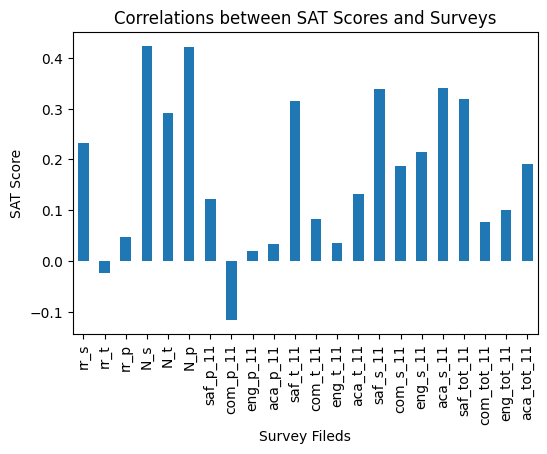

In [14]:
survey_plot = plot_bar_chart(survey_correlations, main_title = 'Correlations between SAT Scores and Surveys')
plt.xlabel('Survey Fileds')
survey_plot;

### Observation

The 'saf_s' which represents safety perception by students have the highest correlation coefficient of all the safety surveys. Hence, this column will be further investigated to determine how it is correlated.

# Investigate Safety Surveys

In [15]:
def scatter_plot(df, col):
    sct_plot = df.plot.scatter(x = col, y = 'sat_score')
    plt.xlabel(None)
    plt.ylabel('SAT Scores')

    return sct_plot

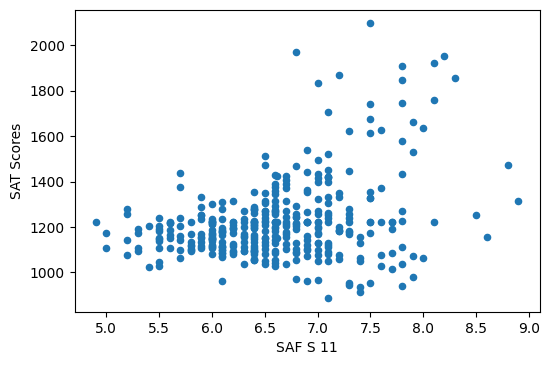

In [16]:
survey_sct_plot = scatter_plot(combined, 'saf_s_11')
plt.xlabel('SAF S 11')
survey_sct_plot;

### Observation on Safety and SAT Scores
There are appears to be a weak positive correlation between survey by students on safety and SAT scores. Despite this, there are few schools with both high safety scores and SAT scores and vice versa. There is however a cluster of schools in the middle with outliers where the safety is perceived high but low SAT score

In [17]:
borough = combined.groupby('boro').agg(np.mean)
borough_average = borough['saf_s_11'].sort_values(ascending=False)
borough_average

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

### Safety Observations
Based on the survey of students on safety, Manhattan is perceived to be the safest while Brooklyn the least safe of the boroughs. 

# Investigate racial differences in SAT scores

In [18]:
race_columns = ['white_per',
               'asian_per',
               'black_per',
               'hispanic_per']

In [19]:
race_correlations = sat_corr(combined, race_columns)
race_correlations

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

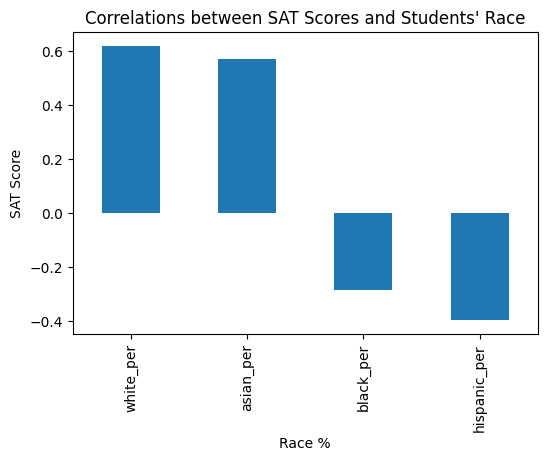

In [20]:
race_plot = plot_bar_chart(race_correlations, main_title = 'Correlations between SAT Scores and Students\' Race' )
plt.xlabel('Race %')
plt.ylabel('SAT Score')
race_plot;

### Race Observation

Schools with high percentage of Whites and Asians have positive correlations with SAT scores. While schools with high percentage of Blacks and Hispanics negatively correlate with SAT scores. 

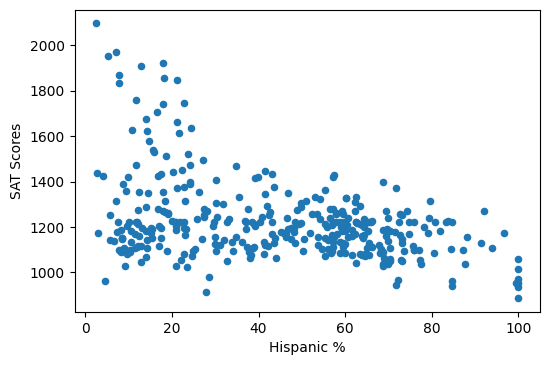

In [21]:
hisp_sct_plot = scatter_plot(combined, 'hispanic_per')
plt.xlabel('Hispanic %')
hisp_sct_plot;

### Hispanic Students Correlations Observation

As stated above, schools with high population of hispanics correlate negatively with SAT Scores. Using the scatterplot to further investigate the correlation reveals a linear weak negative correlation. The less hispanics in the schools, the higher the average SAT scores and vice versa. The outliers in the scatterplot also, show some schools with few hispanic percentage scoring less in SAT

In [22]:
combined[combined['hispanic_per'] > 95] [['SCHOOL NAME', 
                                          'sat_score', 
                                          'hispanic_per']]

,SCHOOL NAME,sat_score,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,99.8
253,MULTICULTURAL HIGH SCHOOL,887.0,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,100.0


### Greater than 95% Hispanic Students Schools Observation

The majority of the schools in the list have more than 95% of their student population being hispanic as they are established to cater for new immigrants mostly from Spanish-speaking countries. The schools are used to help integrate these new immigrants into the society

In [23]:
combined[(combined['hispanic_per'] < 10) & 
         (combined['sat_score'] > 1800)][['SCHOOL NAME', 
                                          'sat_score', 
                                          'hispanic_per']]

,SCHOOL NAME,sat_score,hispanic_per
37,STUYVESANT HIGH SCHOOL,2096.0,2.4
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,7.9
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,5.3


### Observation

The schools in the list above have high academic standards and screen prospective students through entrance exam. They are mostly specialized science and technology schools with rigorous STEM curriculum. Some of the schools receive extra funding from the NYC Department of Education. However, these does not explain the low number of hispanic students.

# Investigate gender differences in SAT scores.

In [24]:
gender_columns = ['male_per', 'female_per']
gender_correlations = sat_corr(combined, gender_columns)
gender_correlations

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

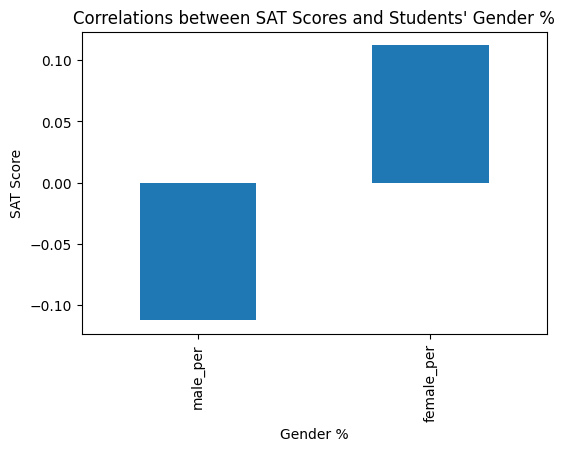

In [25]:
gender_plot = plot_bar_chart(gender_correlations, main_title = 'Correlations between SAT Scores and Students\' Gender %' )
plt.xlabel('Gender %')
gender_plot;

### Gender Correlations Observation
The bar plot posits schools with high female percentage correlates positively with SAT Scores whereas high male percentage correlates negatively with SAT Scores.

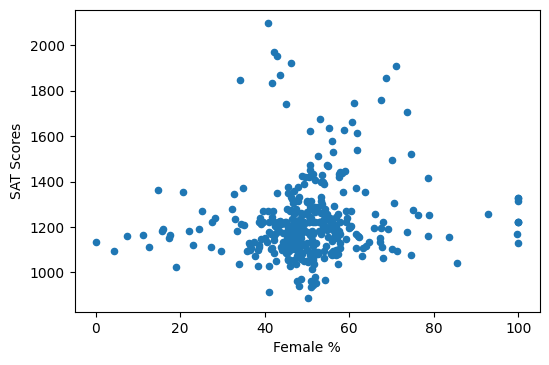

In [26]:
fml_sct_plot = scatter_plot(combined, 'female_per')
plt.xlabel('Female %')
fml_sct_plot;

### Observation 

Further investigation of the data using the scatterplot above reveal  the percentage of female students in a school with SAT Scores show a linear, weak, positive correlation. There are some few schools with a female percentage of more than 60% with average SAT scores exceeding 1700. These schools will be further investigated subsequently

In [27]:
combined[(combined['female_per'] > 60) & 
         (combined['sat_score'] > 1700)][['SCHOOL NAME', 
                                          'sat_score', 
                                          'female_per']]

,SCHOOL NAME,sat_score,female_per
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,67.5
60,BEACON HIGH SCHOOL,1744.0,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,71.1


### Observation

The schools in this list are mostly liberal arts specialized school with equally high academic standards

# Investigate AP Test Takers

In this section, the optional AP Test Takers will be investigated to determine how the percentage of the test takers in a school correlates with SAT Score.

A new column ('ap_per') will be added to dataframe to contain the percentage of the AP Test Takers for each school and subsequently plot the correlation on a scatterplot.

In [28]:
# Calculate the percentage of the test takers in a school
combined['ap_per'] = (combined['AP Test Takers ']) / (combined['total_enrollment']) * 100

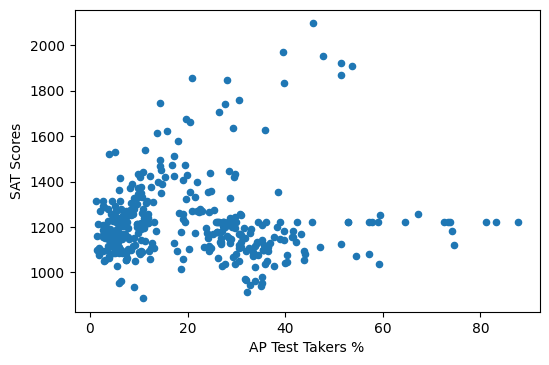

In [29]:
ap_sct_plot = scatter_plot(combined, 'ap_per')
plt.xlabel('AP Test Takers %')
ap_sct_plot;

### Observation

The percentage of AP Test Takers has a linear but weak positive correlation to SAT score with visible outliers. The outliers reveal that some schools with high AP participation scored low in SAT and vice versa 

# Conclusion

The project sought to investigate the correlation (or not) between SAT scores and demographics of high school in the 5 boroughs of New York City using data available on [NYC Open Data](https://opendata.cityofnewyork.us/).

Specifically, demographic factors of students in the high schcools investigated are gender, race and safety perceptions of the boroughs. Also, an additional attribute of other optional test, AP Test was investigated to determine how it correlates with SAT scores.

Subsequently, the results showed, Manhattan was perceived to be the safest borough amongst students while Brooklyn is the least safe.

Also, schools with high percentage of White and Asian students appear to generally have high SAT scores while the opposite is true for schools with high percentage of Black and Hispanic students.

Moreover, the analysis revealed schools where there are large percentage of female students generally have slightly high SAT scores whereas the higher the percentage of male students in a school the lower the schools average SAT score.

Additionally, the percentage of students who took the AP Test did not seem to strongly correlate with SAT scores depsite showing the higher the percentage of students in a high school who took the AP test, the higher the school's average SAT scores, but the increment is not proportional.

There are more columns in the dataset that should be investigated in the future that may reveal interesting findings. For example, 

- the analysis can be mapped on a district level. 
- Also, figure out which neighborhoods have the best schools. this information can be combined with a dataset containing property values, to find the least expensive neighborhoods that have good schools.
- Investigate the differences between parent, teacher, and student responses to surveys.
